<a href="https://colab.research.google.com/github/olinml2024/notebooks/blob/main/ML24_Assignment08_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 8 Companion Notebook (part 2): Neural Network Implementation in Pytorch

Learning Objectives:
* Implement a multi-layer perceptron in pytorch
* Use learning curves to diagnose overfitting
* Learn about (at a conceptual level) three methods for avoiding overfitting.

## Recognizing Digits

Recognizing handwritten digits using machine learning is embedded so thoroughly into the discipline's early history, that anytime someone in the field brings it up at a conference you are likely to elicit groans from the audience.  Feel free to groan at us whenever we mention it in class.

We're going to use a digit recognition dataset that is built into sklearn.  It's not the famous MNIST dataset, but it's the same idea.  Once we've loaded the digits, we'll create some models using pytorch to predict the identity of a digit from its pixels.

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

Here are some sample images from the dataset.

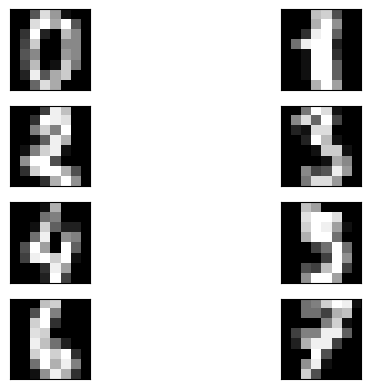

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(4, 2)
axs = axs.flatten()
for i in range(8):
    axs[i].imshow(digits['data'][i,:].reshape((8,8)), cmap='gray')
    axs[i].axes.xaxis.set_visible(False)
    axs[i].axes.yaxis.set_visible(False)

plt.show()

Let's start from where we ended up in class with a logistic regression model in pytorch for this data.

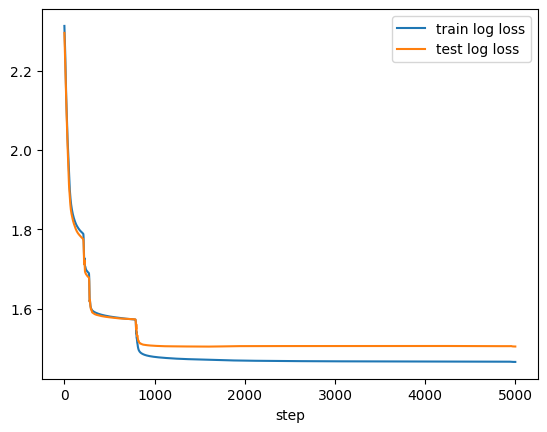

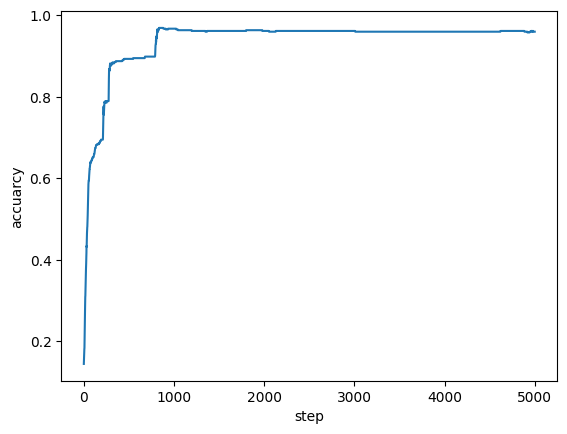

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np

class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        out = self.linear(x)
        out = F.softmax(out, dim=1)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LogisticRegression(64, 10).to(device)

X_train, X_test, y_train, y_test = train_test_split(digits['data'], digits['target'], test_size=0.3, random_state=42)
X_train = torch.from_numpy(X_train.astype(np.float32)).to(device)
y_train = torch.from_numpy(y_train).to(device)
X_test = torch.from_numpy(X_test.astype(np.float32)).to(device)
y_test = torch.from_numpy(y_test).to(device)

n_epochs = 5000
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_losses = np.zeros((n_epochs,))
test_losses = np.zeros((n_epochs,))
accuracies = np.zeros((n_epochs,))

for epoch in range(n_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    train_losses[epoch] = loss.item()

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[epoch] = test_loss.item()
        accuracies[epoch] = (torch.sum(test_outputs.argmax(dim=1) == y_test) / y_test.shape[0]).item()
    loss.backward()
    optimizer.step()

plt.figure()
plt.plot(range(n_epochs), train_losses, label='train log loss')
plt.plot(range(n_epochs), test_losses, label='test log loss')
plt.xlabel('step')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(n_epochs), accuracies)
plt.xlabel('step')
plt.ylabel('accuarcy')
plt.show()

### Exercise 1 (from Notebook 2)

Modify the code above to use an MLP with a variable number of hidden units

In [20]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.linear_1 = nn.Linear(input_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.linear_1(x)
        out = F.sigmoid(out)
        out = self.linear_2(out)
        out = F.softmax(out, dim=1)
        return out

model = MLP(64, 10, 10).to(device)

n_epochs_mlp = 10000
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_losses_mlp = np.zeros((n_epochs_mlp,))
test_losses_mlp = np.zeros((n_epochs_mlp,))
accuracies_mlp = np.zeros((n_epochs_mlp,))

for epoch in range(n_epochs_mlp):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    train_losses_mlp[epoch] = loss.item()

    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses_mlp[epoch] = test_loss.item()
        accuracies_mlp[epoch] = (torch.sum(test_outputs.argmax(dim=1) == y_test) / y_test.shape[0]).item()
    loss.backward()
    optimizer.step()

plt.figure()
plt.plot(range(n_epochs_mlp), train_losses_mlp, label='train log loss (mlp)')
plt.plot(range(n_epochs_mlp), test_losses_mlp, label='test log loss (mlp)')
plt.plot(range(n_epochs), train_losses, label='train log loss (logistic)')
plt.plot(range(n_epochs), test_losses, label='test log loss (logistic)')
plt.xlabel('step')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(n_epochs_mlp), accuracies_mlp, label='accuracy (mlp)')
plt.plot(range(n_epochs), accuracies, label='accuracy (logistic)')
plt.xlabel('step')
plt.legend()
plt.show()

KeyboardInterrupt: 